#### PDX score computations and comparisons

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, gaussian_kde
from sklearn.mixture import GaussianMixture
from forge_class_instance3 import *
%matplotlib inline

/home/sreeramp/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
metadata_mono = pd.read_csv("/home/sreeramp/cancer_dependency_project/sreeram/matrix_factorisation/clean_analysis/data_files/pdx_score_responses.csv", header=0)
exp_data = pd.read_csv("/home/sreeramp/cancer_dependency_project/sreeram/matrix_factorisation/clean_analysis/data_files/pdx_subset_voom_normalised.csv", header = 0, index_col = 0)

In [12]:
exp_data.head()

,A1BG,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AARS,AARS2,...,ZW10,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1658,-2.550759,6.418909,4.736813,6.426247,2.424329,6.279294,3.438024,4.485152,6.887400,2.393692,...,3.656489,3.564658,-2.196577,0.019493,5.459447,-3.465512,5.502872,5.764213,5.014268,6.407049
X-1586,1.852602,5.383232,4.998046,6.820626,3.238541,6.855084,4.855319,4.462583,6.715230,2.720882,...,5.091221,3.696968,-3.473328,-0.471103,4.613938,2.450971,5.173153,5.764221,4.945306,7.022885
X-1993,-2.166238,2.648646,4.758991,5.942586,2.547220,7.672474,5.299082,5.317270,6.562398,3.095887,...,4.797192,2.767659,-2.953064,-0.118784,4.578660,-1.739759,4.622039,6.910935,4.094330,6.556102
X-3843,-9.873323,4.993522,4.798605,7.728861,3.326503,7.052243,5.475786,4.974860,7.581274,2.703870,...,4.906858,4.076960,-0.549142,1.141395,5.153935,0.649259,5.178099,4.986746,5.959394,6.103980
X-1934,2.341811,4.275693,5.423449,6.844165,3.056685,6.520460,5.316835,4.728053,7.116099,2.415013,...,4.681581,3.219141,-0.068201,1.380557,4.850795,3.721517,6.260620,6.455436,5.575059,7.502150


In [4]:
# exp_data = exp_data.T # genes as col

In [13]:
metadata_mono.head()

,pdx_id,T5,T10,T15,T20,pdx_scores,score_cat
0,X-1156,61.4,202.95,184.80,391.7,-6.202504,low_score
1,X-1172,-0.6,74.00,172.05,NaN,-0.386268,low_score
2,X-1323,-18.6,-18.90,27.60,57.2,-6.115833,low_score
3,X-1442,-10.4,-3.00,13.60,NaN,-2.400014,low_score
4,X-1499,10.6,93.20,302.45,NaN,-25.998447,low_score


In [14]:
len(metadata_mono['pdx_id'].unique())

25

#### Get data from OPTUNA model and mygene mapping

In [15]:
gene_imp_df = pd.read_csv('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/EGFR_ERLOTINIB_geneImp_optuna.csv',
header = 0, index_col = 0)
gene_imp_df.head()

,dep_imp,ic50_imp,combined,scaled_combined
MYBL1,-0.000732,0.048128,-0.048860,-0.537553
UBL7-DT,-0.001444,-0.017670,0.016225,0.205589
AK5,0.005105,0.070035,-0.064930,-0.721044
REPS1,-0.000437,-0.068537,0.068100,0.797892
GGN,-0.005745,0.075533,-0.081278,-0.907704


In [16]:
missing_genes = [i for i in gene_imp_df.index if not i in exp_data.columns]
len(missing_genes)

47

In [24]:
gene_imp_df.loc['CDH1']

dep_imp            0.013329
ic50_imp           0.138411
combined          -0.125082
scaled_combined   -1.407854
Name: CDH1, dtype: float64

In [9]:
# with open('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/pdx_fpkm_missing_genes.txt', 'w') as f:
#   f.write('\n'.join(missing_genes))

In [17]:
import mygene

# 1. Initialize MyGene object
mg = mygene.MyGeneInfo()

# 3. Query MyGene for synonyms/aliases
# We want the original symbol, Entrez ID, Ensembl ID, and all synonyms/aliases
results = mg.querymany(
    missing_genes,
    scopes='symbol',         # Input is gene symbols
    fields='entrezgene,ensembl.gene,alias,other_names', # Fields to return
    species='human',         # Specify mouse (or use taxonomy ID 10090)
    returnall=True,          # Get all matches for each query
    as_dataframe=True        # Return as a pandas DataFrame (easier to read)
)

results_df = results['out']

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
4 input query terms found dup hits:	[('ARHGEF34P', 2), ('LRRC59-AS1', 2), ('HLA-V', 9), ('PFN1P6', 2)]


In [18]:
i = 0 # counter for matched missing genes
for hcg_id in gene_imp_df.index:

    # skip if already present
    if hcg_id in exp_data.columns:
        continue

    # fetch alias column (may return scalar or Series)
    try:
        alias_vals = results_df.loc[hcg_id, 'alias']
    except KeyError:
        continue

    # normalize to iterable of rows
    if isinstance(alias_vals, pd.Series):
        alias_iter = alias_vals.values
    else:
        alias_iter = [alias_vals]

    for alias_1 in alias_iter:

        # ---- CASE 1: scalar string ----
        if isinstance(alias_1, str):
            if alias_1 in exp_data.columns:
                i += 1
                print(hcg_id, alias_1)
                exp_data.rename(columns={alias_1: hcg_id}, inplace=True)

        # ---- CASE 2: list / tuple / ndarray of aliases ----
        elif isinstance(alias_1, (list, tuple, np.ndarray)):
            for alias_2 in alias_1:
                if isinstance(alias_2, str) and alias_2 in exp_data.columns:
                    i += 1
                    print(hcg_id, alias_2)
                    exp_data.rename(columns={alias_2: hcg_id}, inplace=True)
        # ---- CASE 3: NaN or anything else → ignore ----
        # no check needed; we just skip it


TNS2 TENC1
NHSL3 KIAA1522
PPP4R3A SMEK1
DSC2 DSC3
NECTIN4 PVRL4
DYNC2I1 WDR60
PATJ INADL
INAVA C1orf106
CRYBG2 AIM1L


In [12]:
# exp_data_norm = np.log2(exp_data + 0.5)

In [13]:
# optuna_fullmodel = FORGE.load_forge(path='/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Models/optuna_models/ERLOTINIB_EGFR_forgeModel_optuna100.pkl')

In [19]:
# create a subset of exp_data
# samples as rows and genes as cols
exp_data_subset = exp_data.loc[metadata_mono['pdx_id'].unique()]
# exp_data_subset = exp_data_subset.T # samples as rows and genes as cols

In [20]:
pdx_hcg_common = list(set(exp_data_subset.columns) & set(gene_imp_df.index))
len(pdx_hcg_common)

163

In [22]:
pdx_hcg_missing = list(set(gene_imp_df.index) - set(exp_data_subset.columns))
len(pdx_hcg_missing)

38

In [23]:
with open('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/pdx_final_missing_genes.txt', 'w') as f:
  f.write('\n'.join(pdx_hcg_missing))

In [16]:
# model_means_df = pd.DataFrame({'mean': optuna_fullmodel.mean_exp,
# 'std': optuna_fullmodel.std_exp}, index=optuna_fullmodel.hcg_list)
# model_means_df.to_csv('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/optuna_model_exp_scaling.csv', index=True)
# model_means_df2 = model_means_df.loc[pdx_hcg_common]
# model_means_df2.shape

In [17]:
exp_data_subset = exp_data_subset[pdx_hcg_common]
exp_data_subset.shape

(25, 163)

In [18]:
exp_data_subset = (
    exp_data_subset
        .groupby(level=0, axis=1)
        .mean()
)

exp_data_subset.shape

/tmp/ipykernel_2457689/1019833162.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(level=0, axis=1)


(25, 163)

In [19]:
scaled_exp_data = (exp_data_subset - exp_data_subset.mean()) / exp_data_subset.std()
scaled_exp_data.shape

(25, 163)

In [20]:
scaled_exp_data.head()

,ACE2,AGPAT1,AKT1S1,ALPK2,ALS2CL,ANKRD52,ANP32A,ANXA3,AREG,ARHGAP31,...,TNS2,TRAM2,TRIM29,TSPAN1,TSPAN4,VAV3,VKORC1,WFS1,YY2,ZCCHC24
X-1156,-1.078643,-0.272651,0.577758,0.206767,-1.253543,-1.228136,0.038213,-1.538535,-1.718976,0.340901,...,0.639746,1.145535,-1.044583,-1.718254,0.395670,-0.017557,0.111177,0.317169,1.451170,1.726198
X-1172,-0.138853,-0.048671,0.304856,-0.425594,-1.812939,0.069571,1.749763,-1.248281,-1.896688,1.127270,...,0.092038,0.264025,-1.548491,-1.617431,-0.956407,0.264504,-0.005326,-0.361920,0.247263,0.477253
X-1323,0.340228,-0.842039,-1.470032,-1.915957,-0.826588,0.375593,0.159679,-1.808243,-0.584928,0.882605,...,0.137933,-0.864041,-0.947275,-0.474745,-0.466755,-0.483730,-2.078472,-1.137410,-0.900236,1.318394
X-1442,1.851999,0.968855,0.055013,0.615434,-0.246847,0.132085,-0.134849,0.257755,-1.226048,1.198905,...,-2.198160,0.307494,0.038970,-0.952889,1.142081,0.299968,-0.204511,-1.350343,0.934717,0.232221
X-1499,-1.094707,2.197853,-1.201448,0.240711,-0.832192,1.165132,1.378865,-2.830671,0.020872,0.694616,...,0.334356,0.344721,-1.061526,-1.396323,-0.141734,-0.812354,-0.299083,-0.291774,0.124448,0.369172


In [21]:
common_genes2 = list(set(gene_imp_df.index) & set(scaled_exp_data.columns))
len(common_genes2)

163

In [22]:
# Compute benefit scores
scaled_exp_data.shape, gene_imp_df.shape

((25, 163), (201, 4))

In [23]:
scaled_exp_data.columns[
    scaled_exp_data.columns.duplicated()
]

Index([], dtype='object')

In [24]:
gene_imp_df['gene' ] = gene_imp_df.index

In [25]:
gene_imp_df_sub = gene_imp_df[gene_imp_df['gene'].isin(common_genes2)]
scaled_exp_data = scaled_exp_data[gene_imp_df_sub.index]
scaled_exp_data.shape, gene_imp_df_sub.shape

((25, 163), (163, 5))

In [26]:
any(scaled_exp_data.columns.duplicated())

False

In [27]:
scaled_exp_data.columns[
    scaled_exp_data.isna().any()
]


Index([], dtype='object')

In [28]:
benefit_scores = scaled_exp_data.values @ gene_imp_df_sub['scaled_combined'].ravel()
benefit_scores_df = pd.DataFrame(benefit_scores, index = scaled_exp_data.index, columns=['raw_benefit_scores'])
benefit_scores_df['scaled_benefit_score'] = (
    (benefit_scores_df['raw_benefit_scores'] - benefit_scores_df['raw_benefit_scores'].min()) /
    (benefit_scores_df['raw_benefit_scores'].max() - benefit_scores_df['raw_benefit_scores'].min())
)

benefit_scores_df.head()

/tmp/ipykernel_2457689/1928991992.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  benefit_scores = scaled_exp_data.values @ gene_imp_df_sub['scaled_combined'].ravel()


,raw_benefit_scores,scaled_benefit_score
X-1156,-8.350013,0.416001
X-1172,-16.807938,0.244704
X-1323,-9.621612,0.390247
X-1442,3.729765,0.660650
X-1499,-3.387771,0.516500


In [29]:
benefit_scores

array([ -8.35001336, -16.8079378 ,  -9.62161244,   3.72976488,
        -3.38777065,   5.32712925,   6.46095092,  -5.30968491,
        -4.4271357 , -28.89045058,  12.42122969,  18.87996005,
         7.12649392,  -7.65540241,   4.39441978,  13.31314915,
        -2.9460372 ,   8.69629191, -15.61180319, -18.31379049,
         3.02880904,   5.92630223,  20.48549761,  17.71628777,
        -6.18464748])

(array([1., 0., 3., 1., 5., 2., 4., 4., 2., 3.]),
 array([-28.89045058, -23.95285576, -19.01526094, -14.07766612,
         -9.1400713 ,  -4.20247648,   0.73511834,   5.67271316,
         10.61030798,  15.5479028 ,  20.48549761]),
 <BarContainer object of 10 artists>)

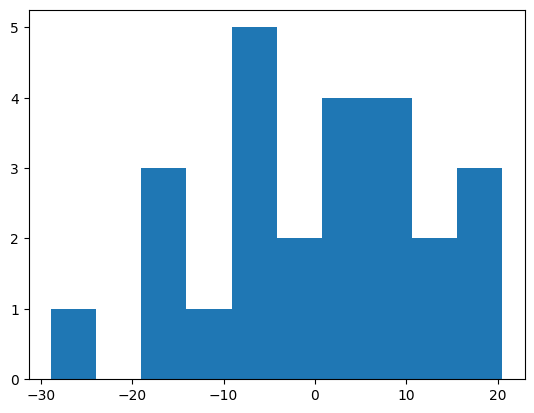

In [30]:
plt.hist(benefit_scores_df['raw_benefit_scores'], bins=10)

Use the above scores to compare tumor volume changes

In [31]:
metadata_mono.head()

,pdx_id,T5,T10,T15,T20,pdx_scores,score_cat
0,X-1156,61.4,202.95,184.80,391.7,-6.202504,low_score
1,X-1172,-0.6,74.00,172.05,NaN,-0.386268,low_score
2,X-1323,-18.6,-18.90,27.60,57.2,-6.115833,low_score
3,X-1442,-10.4,-3.00,13.60,NaN,-2.400014,low_score
4,X-1499,10.6,93.20,302.45,NaN,-25.998447,low_score


In [32]:
metadata_mono.drop(columns = ['pdx_scores', 'score_cat'], inplace=True)

In [33]:
for id in benefit_scores_df.index:
  metadata_mono.loc[metadata_mono['pdx_id'] == id, 'benefit_score_scaled'] = benefit_scores_df.loc[id, 'scaled_benefit_score']
  metadata_mono.loc[metadata_mono['pdx_id'] == id, 'benefit_score'] = benefit_scores_df.loc[id, 'raw_benefit_scores']
  
metadata_mono.head()

,pdx_id,T5,T10,T15,T20,benefit_score_scaled,benefit_score
0,X-1156,61.4,202.95,184.80,391.7,0.416001,-8.350013
1,X-1172,-0.6,74.00,172.05,NaN,0.244704,-16.807938
2,X-1323,-18.6,-18.90,27.60,57.2,0.390247,-9.621612
3,X-1442,-10.4,-3.00,13.60,NaN,0.660650,3.729765
4,X-1499,10.6,93.20,302.45,NaN,0.516500,-3.387771


In [34]:
metadata_mono['benefit_score_scaled'].describe()

count    25.000000
mean      0.585112
std       0.252109
min       0.000000
25%       0.430069
50%       0.646454
75%       0.729443
max       1.000000
Name: benefit_score_scaled, dtype: float64

/tmp/ipykernel_2457689/3381423702.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(metadata_mono['benefit_score_scaled'], shade=True, color='blue')


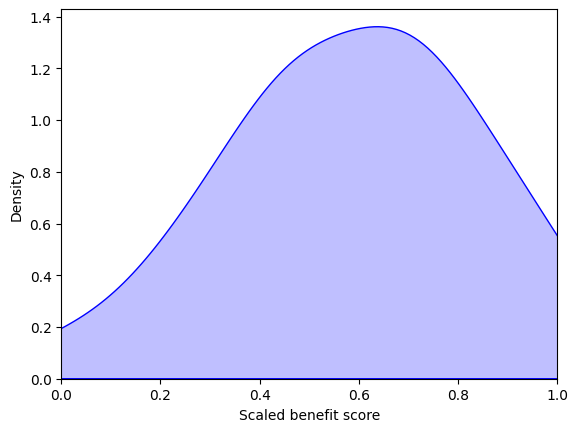

In [35]:
# sns.kdeplot(metadata_mono['new_benefit_score_scaled'], fill=True, color='blue')
sns.kdeplot(metadata_mono['benefit_score_scaled'], shade=True, color='blue')
plt.xlim(0, 1)  # constrain x-axis to actual range
plt.xlabel('Scaled benefit score')
plt.ylabel('Density')
plt.show()

In [36]:
metadata_mono['score_group'] = (
    metadata_mono['benefit_score'] >= metadata_mono['benefit_score'].median()
).map({True: 'high_score', False: 'low_score'})
metadata_mono.head()

,pdx_id,T5,T10,T15,T20,benefit_score_scaled,benefit_score,score_group
0,X-1156,61.4,202.95,184.80,391.7,0.416001,-8.350013,low_score
1,X-1172,-0.6,74.00,172.05,NaN,0.244704,-16.807938,low_score
2,X-1323,-18.6,-18.90,27.60,57.2,0.390247,-9.621612,low_score
3,X-1442,-10.4,-3.00,13.60,NaN,0.660650,3.729765,high_score
4,X-1499,10.6,93.20,302.45,NaN,0.516500,-3.387771,low_score


In [37]:
metadata_mono.loc[metadata_mono['pdx_id'] == 'X-1156', :]

,pdx_id,T5,T10,T15,T20,benefit_score_scaled,benefit_score,score_group
0,X-1156,61.4,202.95,184.8,391.7,0.416001,-8.350013,low_score


In [38]:
metadata_mono.loc[metadata_mono['pdx_id'] == 'X-1499', :]

,pdx_id,T5,T10,T15,T20,benefit_score_scaled,benefit_score,score_group
4,X-1499,10.6,93.2,302.45,NaN,0.5165,-3.387771,low_score


In [39]:
# Melt the DataFrame to long format
long_df = metadata_mono.melt(
    id_vars=['pdx_id', 'benefit_score_scaled', 'benefit_score', 'score_group'],
    value_vars=['T5', 'T10', 'T15', 'T20'],
    var_name='timepoint',
    value_name='value'
)

long_df.head()

,pdx_id,benefit_score_scaled,benefit_score,score_group,timepoint,value
0,X-1156,0.416001,-8.350013,low_score,T5,61.4
1,X-1172,0.244704,-16.807938,low_score,T5,-0.6
2,X-1323,0.390247,-9.621612,low_score,T5,-18.6
3,X-1442,0.660650,3.729765,high_score,T5,-10.4
4,X-1499,0.516500,-3.387771,low_score,T5,10.6


In [40]:
long_df.groupby(['timepoint', 'score_group']).size()

timepoint  score_group
T10        high_score     13
           low_score      12
T15        high_score     13
           low_score      12
T20        high_score     13
           low_score      12
T5         high_score     13
           low_score      12
dtype: int64

In [41]:
from scipy.stats import ttest_ind

In [42]:
other_data = pd.read_csv('/home/sreeramp/cancer_dependency_project/sreeram/matrix_factorisation/clean_analysis/data_files/pdx_other_data.csv', 
                       header = 0, index_col = 0, sep='\t')
other_data.head()

,Treatment,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory
Model,,,,,,,,,
X-1156,erlotinib,single,486.5,20,130.4,13,4.1,20,PD
X-1172,erlotinib,single,186.4,14,46.1,12,8.6,14,PD
X-1323,erlotinib,single,127.7,21,-4.3,11,19.8,41,PD
X-1442,erlotinib,single,13.6,11,0.0,11,11.0,11,SD
X-1499,erlotinib,single,307.7,15,98.8,14,9.4,15,PD


In [43]:
metadata_mono.set_index('pdx_id', inplace=True, drop=False)
metadata_mono.head()

,pdx_id,T5,T10,T15,T20,benefit_score_scaled,benefit_score,score_group
pdx_id,,,,,,,,
X-1156,X-1156,61.4,202.95,184.80,391.7,0.416001,-8.350013,low_score
X-1172,X-1172,-0.6,74.00,172.05,NaN,0.244704,-16.807938,low_score
X-1323,X-1323,-18.6,-18.90,27.60,57.2,0.390247,-9.621612,low_score
X-1442,X-1442,-10.4,-3.00,13.60,NaN,0.660650,3.729765,high_score
X-1499,X-1499,10.6,93.20,302.45,NaN,0.516500,-3.387771,low_score


In [44]:
merged_df = pd.concat([metadata_mono, other_data], join='inner', axis = 1)
df2 = merged_df.sort_values(by = 'BestAvgResponse', axis=0, ascending=False)

In [45]:
merged_df.head()

,pdx_id,T5,T10,T15,T20,benefit_score_scaled,benefit_score,score_group,Treatment,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory
X-1156,X-1156,61.4,202.95,184.80,391.7,0.416001,-8.350013,low_score,erlotinib,single,486.5,20,130.4,13,4.1,20,PD
X-1172,X-1172,-0.6,74.00,172.05,NaN,0.244704,-16.807938,low_score,erlotinib,single,186.4,14,46.1,12,8.6,14,PD
X-1323,X-1323,-18.6,-18.90,27.60,57.2,0.390247,-9.621612,low_score,erlotinib,single,127.7,21,-4.3,11,19.8,41,PD
X-1442,X-1442,-10.4,-3.00,13.60,NaN,0.660650,3.729765,high_score,erlotinib,single,13.6,11,0.0,11,11.0,11,SD
X-1499,X-1499,10.6,93.20,302.45,NaN,0.516500,-3.387771,low_score,erlotinib,single,307.7,15,98.8,14,9.4,15,PD


In [46]:
conditions = [
    (merged_df["BestResponse"] < -95) & (merged_df["BestAvgResponse"] < -40),  # mCR
    (merged_df["BestResponse"] < -50) & (merged_df["BestAvgResponse"] < -20),  # mPR
    (merged_df["BestResponse"] < 35) & (merged_df["BestAvgResponse"] < 30)    # mSD
]

# Define corresponding categories
choices = ["mCR", "mPR", "mSD"]

# Apply conditions, default "mPD"
merged_df["mRECIST"] = np.select(conditions, choices, default="mPD")

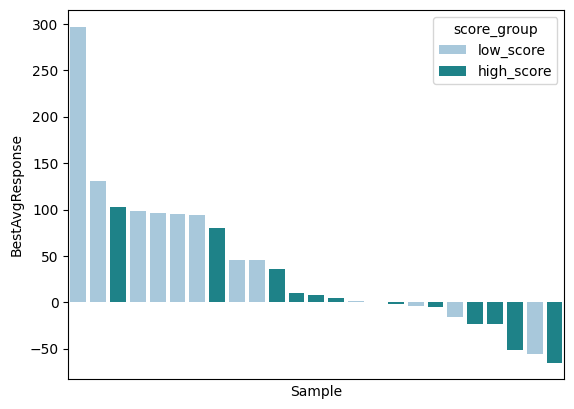

In [47]:
palette = {'high_score': '#0c919a', 'low_score': '#9fcae3'}
sns.barplot(data = df2, x = df2.index, y = 'BestAvgResponse', hue = 'score_group', palette = palette)
plt.xticks([])
plt.xlabel('Sample')
plt.savefig('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/pdx_bestAvgResponses_vommDataScaled.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [48]:
merged_df.columns

Index(['pdx_id', 'T5', 'T10', 'T15', 'T20', 'benefit_score_scaled',
       'benefit_score', 'score_group', 'Treatment', 'Treatment type',
       'BestResponse', 'Day_BestResponse', 'BestAvgResponse',
       'Day_BestAvgResponse', 'TimeToDouble', 'Day_Last', 'ResponseCategory',
       'mRECIST'],
      dtype='object')

In [49]:
merged_df.to_csv('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/pdx_voom_results_datasetScaled.csv',
index=True)

In [50]:
long_df.head()

,pdx_id,benefit_score_scaled,benefit_score,score_group,timepoint,value
0,X-1156,0.416001,-8.350013,low_score,T5,61.4
1,X-1172,0.244704,-16.807938,low_score,T5,-0.6
2,X-1323,0.390247,-9.621612,low_score,T5,-18.6
3,X-1442,0.660650,3.729765,high_score,T5,-10.4
4,X-1499,0.516500,-3.387771,low_score,T5,10.6


In [51]:
long_df['timepoint'].value_counts()

timepoint
T5     25
T10    25
T15    25
T20    25
Name: count, dtype: int64

In [52]:
pd.crosstab(long_df['timepoint'], long_df['score_group'])

score_group,high_score,low_score
timepoint,,
T10,13,12
T15,13,12
T20,13,12
T5,13,12


/tmp/ipykernel_2457689/3546948768.py:33: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


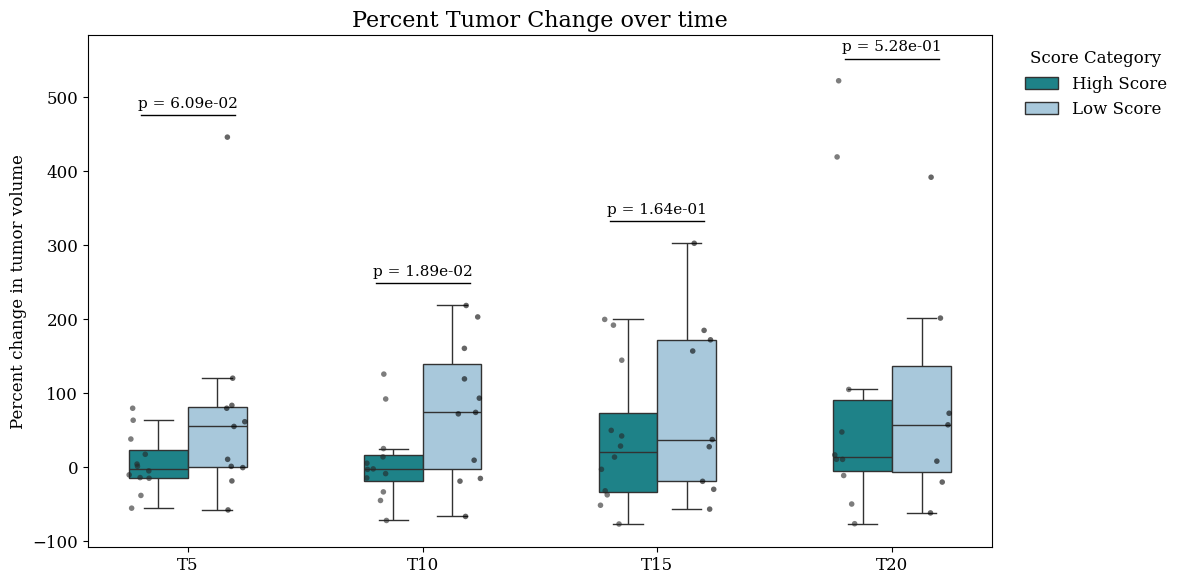

In [53]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind, levene
# -----------------------------
# Configuration
# -----------------------------
palette = {'high_score': '#0c919a', 'low_score': '#9fcae3'}
hue_order = ["high_score", "low_score"]
timepoints = ["T5", "T10", "T15", "T20"]

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12

# -----------------------------
# Figure
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Boxplot
sns.boxplot(
    data=long_df,
    x="timepoint", y="value",
    hue="score_group",
    hue_order=hue_order,
    palette=palette,
    showfliers=False,
    width=0.5,
    ax=ax
)

# Stripplot
sns.stripplot(
    data=long_df,
    x="timepoint", y="value",
    hue="score_group",
    hue_order=hue_order,
    dodge=True,
    jitter=0.1,
    color="black",
    alpha=0.6,
    size=4,
    linewidth=0,
    ax=ax
)

# -----------------------------
# One-sided Mann–Whitney U tests
# H1: high_score < low_score
# -----------------------------
pvals = {}


pvals = {}
var_tests = {}

for tp in timepoints:
    x = long_df.query(
        "timepoint == @tp and score_group == 'high_score'"
    )["value"].dropna()

    y = long_df.query(
        "timepoint == @tp and score_group == 'low_score'"
    )["value"].dropna()

    # Skip if insufficient data
    if len(x) < 2 or len(y) < 2:
        pvals[tp] = np.nan
        var_tests[tp] = np.nan
        continue

    # Brown–Forsythe (Levene with median)
    stat_var, p_var = levene(x, y, center="median")
    equal_var = p_var > 0.05   # fail to reject equal variances

    # t-test
    _, p = ttest_ind(
        x, y,
        alternative="less",
        equal_var=equal_var
    )

    pvals[tp] = p
    var_tests[tp] = p_var

# -----------------------------
# Manual annotation
# -----------------------------
xticks = {t.get_text(): i for i, t in enumerate(ax.get_xticklabels())}
y_range = long_df["value"].max() - long_df["value"].min()
y_offset = 0.05 * y_range

for tp, p in pvals.items():
    x = xticks[tp]
    y = long_df.loc[long_df["timepoint"] == tp, "value"].max() + y_offset

    # bracket
    ax.plot([x - 0.2, x + 0.2], [y, y], color="black", lw=1)

    # p-value text
    ax.text(
        x,
        y + 0.2 * y_offset,
        f"p = {p:.2e}",
        ha="center",
        va="bottom",
        fontsize=11
    )

# -----------------------------
# Legend cleanup (remove duplicate)
# -----------------------------
handles, labels = ax.get_legend_handles_labels()
label_map = {'high_score': 'High Score', 'low_score': 'Low Score'}

ax.legend(
    handles[:2],
    [label_map[l] for l in labels[:2]],
    title="Score Category",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    frameon=False
)

# -----------------------------
# Final formatting
# -----------------------------
ax.set_title("Percent Tumor Change over time", fontsize=16)
ax.set_xlabel("")
ax.set_ylabel("Percent change in tumor volume")
# ax.set_ylim(-200, 700)

plt.tight_layout()
plt.savefig('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/pdx_tvChange_VoomDataScaled.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [54]:
var_tests

{'T5': np.float64(0.14177233535802358),
 'T10': np.float64(0.06836685477584296),
 'T15': np.float64(0.3556211883395758),
 'T20': np.float64(0.8297502614131669)}

All the above pairs have equal variances as per p > 0.05 for levene test

#### Chisquare test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
%matplotlib inline

In [2]:
merged_df = pd.read_csv('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/pdx_voom_results_datasetScaled.csv',
index_col=0, header = 0)
merged_df.head()

,pdx_id,T5,T10,T15,T20,benefit_score_scaled,benefit_score,score_group,Treatment,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory,mRECIST
X-1156,X-1156,61.4,202.95,184.80,391.7,0.416001,-8.350013,low_score,erlotinib,single,486.5,20,130.4,13,4.1,20,PD,mPD
X-1172,X-1172,-0.6,74.00,172.05,NaN,0.244704,-16.807938,low_score,erlotinib,single,186.4,14,46.1,12,8.6,14,PD,mPD
X-1323,X-1323,-18.6,-18.90,27.60,57.2,0.390247,-9.621612,low_score,erlotinib,single,127.7,21,-4.3,11,19.8,41,PD,mPD
X-1442,X-1442,-10.4,-3.00,13.60,NaN,0.660650,3.729765,high_score,erlotinib,single,13.6,11,0.0,11,11.0,11,SD,mSD
X-1499,X-1499,10.6,93.20,302.45,NaN,0.516500,-3.387771,low_score,erlotinib,single,307.7,15,98.8,14,9.4,15,PD,mPD


In [7]:
contingency = pd.crosstab(merged_df["score_group"], merged_df["mRECIST"])
print(contingency)

mRECIST      mPD  mPR  mSD
score_group               
high_score     5    2    6
low_score      9    1    2


In [8]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected counts:\n", expected)


Chi-square: 3.441697191697192
p-value: 0.1789142575776197
Degrees of freedom: 2
Expected counts:
 [[7.28 1.56 4.16]
 [6.72 1.44 3.84]]


In [9]:
table = pd.DataFrame(contingency)
n = table.to_numpy().sum()
r, k = table.shape

cramers_v = np.sqrt(chi2 / (n * (min(r, k) - 1)))

print("Chi-square:", chi2)
print("Cramér's V:", cramers_v)

Chi-square: 3.441697191697192
Cramér's V: 0.37103623497966837


In [10]:
table

mRECIST,mPD,mPR,mSD
score_group,,,
high_score,5,2,6
low_score,9,1,2


In [ ]:
phi2 = chi2 / n
r, k = table.shape

phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
r_corr = r - (r-1)**2/(n-1)
k_corr = k - (k-1)**2/(n-1)

cramers_v_corr = np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

print("Bias-corrected Cramér's V:", cramers_v_corr)
